## Tutorial 08 - Non linear Parabolic problem
**_Keywords: exact parametrized functions, POD-Galerkin_**

### 1. Introduction

In this tutorial, we consider the FitzHugh-Nagumo (F-N) system. The F-N system is used to describe neuron excitable systems. The nonlinear parabolic problem for the F-N system is defined on the interval $I=[0,L]$. 

![mesh](data/mesh.png)

Let $x\in I$, $t\geq0$

$$\begin{cases} 
    \varepsilon u_t(x,t) =\varepsilon^2u_{xx}(x,t)+g(u(x,t))-\omega(x,t)+c, & x\in I,\quad t\geq 0, \\
    \omega_t(x,t) =bu(x,t)-\gamma\omega(x,t)+c, & x\in I,\quad t\geq 0, \\
    u(x,0) = 0,\quad\omega(x,0)=0, & x\in I, \\
    u_x(0,t)=-i_0(t),\quad u_x(L,t)=0, & t\geq 0,
\end{cases}$$

where the nonlinear function is defined by
$$g(u) = u(u-0.1)(1-u)$$

and the parameters are given by $L = 1$, $\varepsilon = 0.015$, $b = 0.5$, $\gamma = 2$, and $c = 0.05$. The stimulus $i_0(t)=50000t^3\exp(-15t)$. The variables $u$ and $\omega$ represent the $\textit{voltage}$ and the $\textit{recovery of voltage}$, respectively. 

In order to obtain an exact solution of the problem we pursue a model reduction by means of a POD-Galerkin reduced order method.

### 2. Formulation for the F-N system

Let $u,\omega$ the solutions in the domain $I$.

For this problem we want to find $\boldsymbol{u}=(u,\omega)$ such that

$$
m\left(\partial_t\boldsymbol{u}(t),\boldsymbol{v}\right)+a\left(\boldsymbol{u}(t),\boldsymbol{v}\right)+c\left(u(t),v\right)=f(\boldsymbol{v})\quad \forall \boldsymbol{v}=(v,\tilde{v}), \text{ with }v,\tilde{v} \in\mathbb{V},\quad\forall t\geq0
$$



where

* the function space $\mathbb{V}$ is defined as
$$
\mathbb{V} = \{v\in L^2(I) : v|_{\{0\}}=0\}
$$
* the bilinear form $m(\cdot, \cdot): \mathbb{V} \times \mathbb{V} \to \mathbb{R}$ is defined by
$$
m(\partial\boldsymbol{u}(t), \boldsymbol{v})=\varepsilon\int_{I}\frac{\partial u}{\partial t}v \ d\boldsymbol{x} \ + \ \int_{I}\frac{\partial\omega}{\partial t}\tilde{v} \ d\boldsymbol{x},
$$
* the bilinear form $a(\cdot, \cdot): \mathbb{V} \times \mathbb{V} \to \mathbb{R}$ is defined by
$$
a(\boldsymbol{u}(t), \boldsymbol{v})=\varepsilon^2\int_{I} \nabla u\cdot \nabla v \ d\boldsymbol{x}+\int_{I}\omega v \ d\boldsymbol{x} \ - \ b\int_{I} u\tilde{v} \ d\boldsymbol{x}+\gamma\int_{I}\omega\tilde{v} \ d\boldsymbol{x},
$$
* the bilinear form $c(\cdot, \cdot): \mathbb{V} \times \mathbb{V} \to \mathbb{R}$ is defined by
$$
c(u, v)=-\int_{I} g(u)v \ d\boldsymbol{x},
$$
* the linear form $f(\cdot): \mathbb{V} \to \mathbb{R}$ is defined by
$$
f(\boldsymbol{v})= c\int_{I}\left(v+\tilde{v}\right) \ d\boldsymbol{x} \ + \ \varepsilon^2i_0(t)\int_{\{0\}}v \ d\boldsymbol{s}.
$$

The output of interest $s(t)$ is given by
$$
s(t) = c\int_{I}\left[u(t)+\omega(t)\right] \ d\boldsymbol{x} \ + \ \varepsilon^2i_0(t)\int_{\{0\}}u(t) \ d\boldsymbol{s}. 
$$

In [1]:
import os
import sys
sys.path.append('../../')

from mlnics import NN, Losses, Normalization, RONNData, IO, Training, ErrorAnalysis
from dolfin import *
from rbnics import *
import torch
import numpy as np

torch.manual_seed(0)
np.random.seed(0)

### 3. Affine Decomposition 

We set the variables $u:=u_1$, $\omega:=u_2$ and the test functions $v:=v_1$, $\tilde{v}:=v_2$.
For this problem the affine decomposition is straightforward:
    $$m(\boldsymbol{u},\boldsymbol{v})=\underbrace{\varepsilon}_{\Theta^{m}_0}\underbrace{\int_{I}u_1v_1 \ d\boldsymbol{x}}_{m_0(u_1,v_1)} \ + \ \underbrace{1}_{\Theta^{m}_1}\underbrace{\int_{I}u_2v_2 \ d\boldsymbol{x}}_{m_1(u_2,v_2)},$$
$$a(\boldsymbol{u},\boldsymbol{v})=\underbrace{\varepsilon^2}_{\Theta^{a}_0}\underbrace{\int_{I}\nabla u_1 \cdot \nabla v_1 \ d\boldsymbol{x}}_{a_0(u_1,v_1)} \ + \ \underbrace{1}_{\Theta^{a}_1}\underbrace{\int_{I}u_2v_1 \ d\boldsymbol{x}}_{a_1(u_2,v_1)} \ + \ \underbrace{-b}_{\Theta^{a}_2}\underbrace{\int_{I}u_1v_2 \ d\boldsymbol{x}}_{a_2(u_1,v_2)} \ + \ \underbrace{\gamma}_{\Theta^{a}_3}\underbrace{\int_{I}u_2v_2 \ d\boldsymbol{x}}_{a_3(u_2,v_2)},$$
$$c(u,v)=\underbrace{-1}_{\Theta^{c}_0}\underbrace{\int_{I}g(u_1)v_1 \ d\boldsymbol{x}}_{c_0(u_1,v_1)},$$
$$f(\boldsymbol{v}) = \underbrace{c}_{\Theta^{f}_0} \underbrace{\int_{I}(v_1 + v_2) \ d\boldsymbol{x}}_{f_0(v_1,v_2)} \ + \ \underbrace{\varepsilon^2i_0(t)}_{\Theta^{f}_1} \underbrace{\int_{\{0\}} v_1 \ d\boldsymbol{s}}_{f_1(v_1)}.$$
We will implement the numerical discretization of the problem in the class
```
class FitzHughNagumo(NonlinearParabolicProblem):
```
by specifying the coefficients $\Theta^{m}_*$, $\Theta^{a}_*$, $\Theta^{c}_*$ and $\Theta^{f}_*$ in the method
```
    def compute_theta(self, term):
```
and the bilinear forms $m_*(\boldsymbol{u}, \boldsymbol{v})$, $a_*(\boldsymbol{u}, \boldsymbol{v})$, $c_*(u, v)$ and linear forms $f_*(\boldsymbol{v})$ in
```
    def assemble_operator(self, term):
```

In [2]:
@ExactParametrizedFunctions()
class FitzHughNagumo(NonlinearParabolicProblem):

    # Default initialization of members
    def __init__(self, V, **kwargs):
        # Call the standard initialization
        NonlinearParabolicProblem.__init__(self, V, **kwargs)
        # ... and also store FEniCS data structures for assembly
        assert "subdomains" in kwargs
        assert "boundaries" in kwargs
        self.subdomains, self.boundaries = kwargs["subdomains"], kwargs["boundaries"]
        self.du = TrialFunction(V)
        (self.du1, self.du2) = split(self.du)
        self.u = self._solution
        (self.u1, self.u2) = split(self.u)
        self.v = TestFunction(V)
        (self.v1, self.v2) = split(self.v)
        self.dx = Measure("dx")(subdomain_data=self.subdomains)
        self.ds = Measure("ds")(subdomain_data=self.boundaries)
        # Problem coefficients
        self.epsilon = 0.015
        self.b = 0.5
        self.gamma = 2
        self.c = 0.05
        self.i0 = lambda t: 50000 * t**3 * exp(-15 * t)
        self.g = lambda v: v * (v - 0.1) * (1 - v)
        # Customize time stepping parameters
        self._time_stepping_parameters.update({
            "report": True,
            "snes_solver": {
                "linear_solver": "umfpack",
                "maximum_iterations": 20,
                "report": True
            }
        })

    # Return custom problem name
    def name(self):
        return "FitzHughNagumoExact"

    # Return theta multiplicative terms of the affine expansion of the problem.
    @compute_theta_for_derivatives
    def compute_theta(self, term):
        if term == "m":
            theta_m0 = self.epsilon
            theta_m1 = 1.
            return (theta_m0, theta_m1)
        elif term == "a":
            theta_a0 = self.epsilon**2
            theta_a1 = 1.
            theta_a2 = - self.b
            theta_a3 = self.gamma
            return (theta_a0, theta_a1, theta_a2, theta_a3)
        elif term == "c":
            theta_c0 = - 1.
            return (theta_c0,)
        elif term == "f":
            t = self.t
            theta_f0 = self.c
            theta_f1 = self.epsilon**2 * self.i0(t)
            return (theta_f0, theta_f1)
        elif term == "s":
            t = self.t
            theta_s0 = self.c
            theta_s1 = self.epsilon**2 * self.i0(t)
            return (theta_s0, theta_s1)
        else:
            raise ValueError("Invalid term for compute_theta().")

    # Return forms resulting from the discretization of the affine expansion of the problem operators.
    @assemble_operator_for_derivatives
    def assemble_operator(self, term):
        (v1, v2) = (self.v1, self.v2)
        dx = self.dx
        if term == "m":
            (u1, u2) = (self.du1, self.du2)
            m0 = u1 * v1 * dx
            m1 = u2 * v2 * dx
            return (m0, m1)
        elif term == "a":
            (u1, u2) = (self.du1, self.du2)
            a0 = inner(grad(u1), grad(v1)) * dx
            a1 = u2 * v1 * dx
            a2 = u1 * v2 * dx
            a3 = u2 * v2 * dx
            return (a0, a1, a2, a3)
        elif term == "c":
            u1 = self.u1
            c0 = self.g(u1) * v1 * dx
            return (c0,)
        elif term == "f":
            ds = self.ds
            f0 = v1 * dx + v2 * dx
            f1 = v1 * ds(1)
            return (f0, f1)
        elif term == "s":
            (v1, v2) = (self.v1, self.v2)
            ds = self.ds
            s0 = v1 * dx + v2 * dx
            s1 = v1 * ds(1)
            return (s0, s1)
        elif term == "inner_product":
            (u1, u2) = (self.du1, self.du2)
            x0 = inner(grad(u1), grad(v1)) * dx + u2 * v2 * dx
            return (x0,)
        else:
            raise ValueError("Invalid term for assemble_operator().")


# Customize the resulting reduced problem
@CustomizeReducedProblemFor(NonlinearParabolicProblem)
def CustomizeReducedNonlinearParabolic(ReducedNonlinearParabolic_Base):
    class ReducedNonlinearParabolic(ReducedNonlinearParabolic_Base):
        def __init__(self, truth_problem, **kwargs):
            ReducedNonlinearParabolic_Base.__init__(self, truth_problem, **kwargs)
            self._time_stepping_parameters.update({
                "report": True,
                "nonlinear_solver": {
                    "report": True,
                    "line_search": "wolfe"
                }
            })

    return ReducedNonlinearParabolic

## 4. Main program

### 4.1. Read the mesh for this problem
The mesh was generated by the [data/generate_mesh.ipynb](data/generate_mesh.ipynb) notebook.

In [3]:
mesh = Mesh("data/interval.xml")
subdomains = MeshFunction("size_t", mesh, "data/interval_physical_region.xml")
boundaries = MeshFunction("size_t", mesh, "data/interval_facet_region.xml")

### 4.2. Create Finite Element space (Lagrange P1)

In [4]:
V = VectorFunctionSpace(mesh, "Lagrange", 1, dim=2)

### 4.3. Allocate an object of the FitzHughNagumo class

In [5]:
problem = FitzHughNagumo(V, subdomains=subdomains, boundaries=boundaries)
mu_range = []
problem.set_mu_range(mu_range)
problem.set_time_step_size(0.02)
problem.set_final_time(8)

### 4.4. Prepare reduction with a POD-Galerkin method

In [6]:
reduction_method = PODGalerkin(problem)
reduction_method.set_Nmax(20)

### 4.5. Perform the offline phase

#### 4.5.1 Fit Reduction Method

In [7]:
reduction_method.initialize_training_set(1)
reduced_problem = reduction_method.offline()

=            FitzHughNagumoExact POD-Galerkin offline phase begins             =

###################################### 0 #######################################
truth solve for mu = ()
# t = 0.02
  0 SNES Function norm 2.210911e-03
  1 SNES Function norm 1.063340e-04
  2 SNES Function norm 6.047399e-07
  3 SNES Function norm 1.982447e-11
# t = 0.04
  0 SNES Function norm 2.849024e-03
  1 SNES Function norm 1.010348e-04
  2 SNES Function norm 5.953550e-07
  3 SNES Function norm 2.184160e-11
# t = 0.06
  0 SNES Function norm 3.734542e-03
  1 SNES Function norm 1.217784e-04
  2 SNES Function norm 7.911830e-07
  3 SNES Function norm 3.547206e-11
# t = 0.08
  0 SNES Function norm 4.968389e-03
  1 SNES Function norm 1.423033e-04
  2 SNES Function norm 3.604419e-07
  3 SNES Function norm 2.124305e-12
# t = 0.1
  0 SNES Function norm 6.954749e-03
  1 SNES Function norm 5.282859e-04
  2 SNES Function norm 3.852334e-05
  3 SNES Function norm 2.557857e-07
  4 SNES Function norm 1.124143e-11
# t

#### 4.5.2 Train PINN

Given a training set $\Xi_{PINN} = (\boldsymbol{\mu}^{(1)}, \dots, \boldsymbol{\mu}^{(N_\text{PINN})})$ of parameters for the PDE, we train a Physics-Informed Neural Network (PINN) $u^{NN}(\boldsymbol{\mu})$ for the reduced order equations dependent on the weights and biases $W$ of the network to minimize the loss function

$$L_{PINN}(\Xi_{PINN}; W) = \frac{1}{N_\text{PINN}} \sum_{i=1}^{N_\text{PINN}} \|M(\boldsymbol{\mu^{(i)}})\frac{\partial u^{NN}}{\partial t}(\boldsymbol{\mu^{(i)}}; W) + A(\boldsymbol{\mu^{(i)}}) u^{NN}(\boldsymbol{\mu}^{(i)}; W) - \boldsymbol{f}(\boldsymbol{\mu}^{(i)}) + \boldsymbol{c}(\boldsymbol{\mu}^{(i)})\|_2^2$$

over $W$, where for a given $\boldsymbol{\mu}$, $M(\boldsymbol{\mu})$ is the mass matrix corresponding to the bilinear form $m$, $A(\boldsymbol{\mu})$ is the assembled reduced matrix corresponding to the bilinear form $a$ and $\boldsymbol{f}(\boldsymbol{\mu})$ is the assembled reduced vector corresponding to the linear form $f$, and $\boldsymbol{c}(\boldsymbol{\mu})$ is a vector corresponding to the nonlinear form $c$. The partial derivative $\frac{\partial u^{NN}}{\partial t}(\boldsymbol{\mu^{(i)}}; W)$ is computed via automatic differentiation in PyTorch.

In [8]:
input_normalization_pinn = Normalization.MinMaxNormalization(input_normalization=True)
output_normalization_pinn = Normalization.MinMaxNormalization()

pinn_net  = NN.RONN("PINN", problem, reduction_method, n_hidden=2, n_neurons=40)
pinn_loss = Losses.PINN_Loss(pinn_net, output_normalization_pinn)
data      = RONNData.RONNDataLoader(pinn_net, validation_proportion=0.2, 
                                    num_without_snapshots=1)
optimizer = torch.optim.Adam(pinn_net.parameters(), lr=0.001)
scheduler = torch.optim.lr_scheduler.ExponentialLR(optimizer, 0.99999)

pinn_trainer = Training.PINNTrainer(
    pinn_net, data, pinn_loss, optimizer, scheduler,
    input_normalization_pinn, num_epochs=10000
)

loaded, starting_epoch = IO.initialize_parameters(
    pinn_net, data, pinn_trainer, optimizer
)

In [9]:
pinn_trainer.train()

  0%|          | 0/10000 [00:00<?, ?it/s]

Operator 'c' not implemented. Continuing without operator 'c'...
Operator 'dc' not implemented. Continuing without operator 'dc'...
Operator 's' not implemented. Continuing without operator 's'...


100%|██████████| 10000/10000 [03:34<00:00, 46.71it/s, Loss(training)=0.0919]


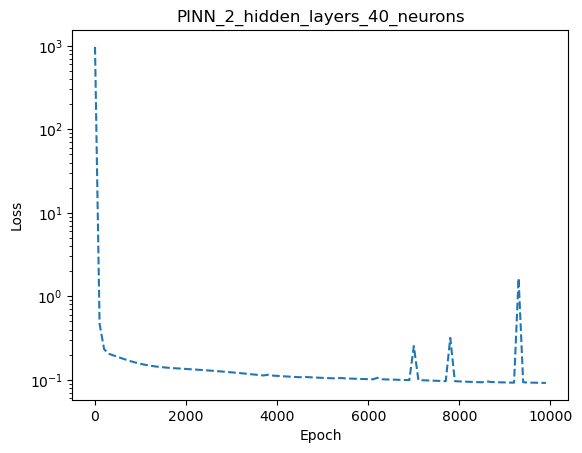

In [10]:
fig, ax = Training.plot_loss(pinn_trainer, pinn_net)

#### 4.5.3 Train PDNN

Given a training set $\Xi_{PDNN} = ((\boldsymbol{\mu}^{(1)}, u^{\text{HF}}(\boldsymbol{\mu}^{(1)})), \dots, (\boldsymbol{\mu}^{(N_\text{PDNN})}, u^{\text{HF}}(\boldsymbol{\mu}^{(N_\text{PDNN})})))$ of parameter and high fidelity solution pairs for the PDE, we train a Projection-Driven Neural Network (PDNN) $\operatorname{N}_W(\boldsymbol{\mu})$ dependent on the weights and biases $W$ of the network to minimize the loss function
$$L_{PDNN}(\Xi_{PDNN}; W) = \frac{1}{N_\text{PDNN}} \sum_{i=1}^{N_\text{PDNN}} \|u^{NN}(\boldsymbol{\mu}^{(i)}; W) - U^T u^{\text{HF}}(\boldsymbol{\mu}^{(i)})\|_2^2,$$
where for a given $\boldsymbol{\mu}$, the quantity $U^T u^{\text{HF}}(\boldsymbol{\mu})$ is the projection of the high fidelity solution $u^{\text{HF}}(\boldsymbol{\mu})$ onto the reduced order space.

In [13]:
input_normalization_pdnn = Normalization.StandardNormalization(input_normalization=True)
output_normalization_pdnn = Normalization.StandardNormalization()

pdnn_net  = NN.RONN("PDNN", problem, reduction_method, n_hidden=2, n_neurons=40)
pdnn_loss = Losses.PDNN_Loss(pdnn_net, output_normalization_pdnn)
data      = RONNData.RONNDataLoader(pdnn_net, validation_proportion=0.2)
optimizer = torch.optim.Adam(pdnn_net.parameters(), lr=0.001)

pdnn_trainer = Training.PDNNTrainer(
    pdnn_net, data, pdnn_loss, optimizer, scheduler,
    input_normalization_pdnn, num_epochs=10000
)

loaded, starting_epoch = IO.initialize_parameters(
    pdnn_net, data, pdnn_trainer, optimizer
)

In [14]:
pdnn_trainer.train()

100%|██████████| 10000/10000 [00:14<00:00, 700.89it/s, Loss(training)=0.0717]


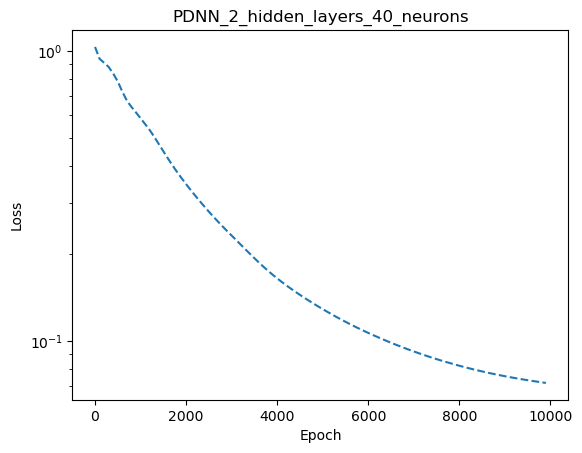

In [15]:
fig, ax = Training.plot_loss(pdnn_trainer, pdnn_net)

#### 4.5.4 Train PRNN

We train a Physics-Reinforced Neural Network (PRNN) $N_W(\boldsymbol{\mu})$ dependent on the weights and biases $W$ of the network to minimize the loss function

$$L_{PRNN}(\Xi_{PINN}, \Xi_{PDNN}; W) = L_{PINN}(\Xi_{PINN}; W) + \omega L_{PDNN}(\Xi_{PDNN}; W)$$

where $\omega$ is a scaling parameter which can be chosen freely.

In [16]:
input_normalization_prnn = Normalization.StandardNormalization(input_normalization=True)
output_normalization_prnn = Normalization.StandardNormalization()

omega = 1.
prnn_net  = NN.RONN(f"PRNN_{omega}", problem, reduction_method, n_hidden=2, n_neurons=40)
prnn_loss = Losses.PRNN_Loss(prnn_net, output_normalization_prnn, omega=omega)
data      = RONNData.RONNDataLoader(prnn_net, validation_proportion=0.2,
                                    num_without_snapshots=100)
optimizer = torch.optim.Adam(prnn_net.parameters(), lr=0.001)
scheduler = torch.optim.lr_scheduler.ExponentialLR(optimizer, 0.99999)

prnn_trainer = Training.PRNNTrainer(
    prnn_net, data, prnn_loss, optimizer, scheduler,
    input_normalization_prnn, num_epochs=10000
)

loaded, starting_epoch = IO.initialize_parameters(
    prnn_net, data, prnn_trainer, optimizer
)

In [17]:
prnn_trainer.train()

  0%|          | 0/10000 [00:00<?, ?it/s]

Operator 'c' not implemented. Continuing without operator 'c'...
Operator 'dc' not implemented. Continuing without operator 'dc'...
Operator 's' not implemented. Continuing without operator 's'...


100%|██████████| 10000/10000 [2:42:20<00:00,  1.03it/s, Loss(training)=1.03]    


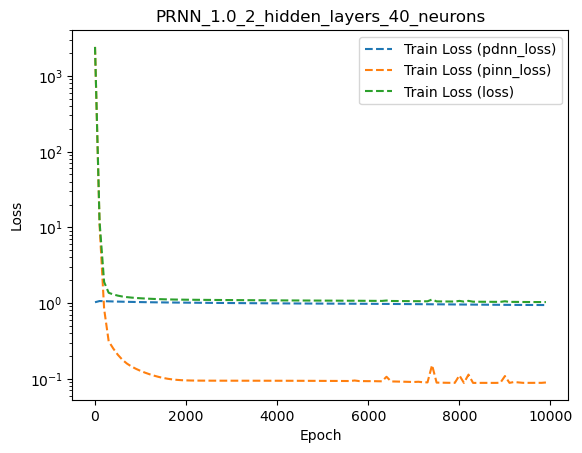

In [18]:
fig, ax = Training.plot_loss(prnn_trainer, prnn_net, separate=True)

### 4.6. Perform an error analysis

#### 4.6.1 Reduction Method Error Analysis

In [19]:
np.random.seed(0)

reduction_method.initialize_testing_set(1)
test_set_mu = torch.tensor(reduction_method.testing_set)
online_mu = tuple(np.array(reduction_method.testing_set)[0, :])

#### 4.6.2 PINN Error Analysis

In [22]:
_ = ErrorAnalysis.error_analysis_fixed_net(
    pinn_net, test_set_mu, input_normalization_pinn, output_normalization_pinn, relative=False
)

# t = 0.02


0:  |F(x)| = 1.19919; step 1
1:  |F(x)| = 0.00681881; step 1
2:  |F(x)| = 2.23389e-07; step 1
scipy solver converged in 4 iterations.
# t = 0.04
0:  |F(x)| = 1.13476; step 1
1:  |F(x)| = 0.00662497; step 1
2:  |F(x)| = 2.31479e-07; step 1
scipy solver converged in 4 iterations.
# t = 0.06
0:  |F(x)| = 1.34724; step 1
1:  |F(x)| = 0.0085941; step 1
2:  |F(x)| = 3.55184e-07; step 1
scipy solver converged in 4 iterations.
# t = 0.08
0:  |F(x)| = 1.55701; step 1
1:  |F(x)| = 0.00371152; step 1
2:  |F(x)| = 2.18598e-08; step 1
scipy solver converged in 4 iterations.
# t = 0.1
0:  |F(x)| = 2.28427; step 1
1:  |F(x)| = 0.0949969; step 1
2:  |F(x)| = 0.000551921; step 1
3:  |F(x)| = 2.30374e-08; step 1
scipy solver converged in 5 iterations.
# t = 0.12
0:  |F(x)| = 16.4716; step 1
1:  |F(x)| = 0.966483; step 1
2:  |F(x)| = 0.00390647; step 1
3:  |F(x)| = 6.49569e-08; step 1
scipy solver converged in 5 iterations.
# t = 0.14
0:  |F(x)| = 12.9491; step 1
1:  |F(x)| = 0.446753; step 1
2:  |F(x)| 

#### 4.6.3 PDNN Error Analysis

In [23]:
_ = ErrorAnalysis.error_analysis_fixed_net(
    pdnn_net, test_set_mu, input_normalization_pdnn, output_normalization_pdnn, relative=True
)

################################# PDNN N = 20 ##################################
ERROR	NN-HF			NN-RO			RO-HF
min	0.001542718943333539	0.0016917368754717347	0.0
mean	266.07421665294584	266.07437873758136	0.0033552888716847393
max	106670.7049950226	106670.7049950226	0.023798511071273572


#### 4.6.4 PRNN Error Analysis

In [24]:
_ = ErrorAnalysis.error_analysis_fixed_net(
    prnn_net, test_set_mu, input_normalization_prnn, output_normalization_prnn, relative=False
)

############################### PRNN_1.0 N = 20 ################################
ERROR	NN-HF			NN-RO			RO-HF
min	0.04295596254557328	0.04295075970187172	0.0
mean	0.171816142946302	0.1718213383920106	0.00031473405535774085
max	1.455622865740406	1.4556208374163764	0.0013749948506991117


#### 4.6.5 Neural Network Error Comparison

In [25]:
nets = dict()
nets["pinn_net"] = pinn_net
nets["pdnn_net"] = pdnn_net
nets["prnn_net"] = prnn_net

input_normalizations = dict()
input_normalizations["pinn_net"] = input_normalization_pinn
input_normalizations["pdnn_net"] = input_normalization_pdnn
input_normalizations["prnn_net"] = input_normalization_prnn

output_normalizations = dict()
output_normalizations["pinn_net"] = output_normalization_pinn
output_normalizations["pdnn_net"] = output_normalization_pdnn
output_normalizations["prnn_net"] = output_normalization_prnn

_ = ErrorAnalysis.error_analysis_by_network(
    nets, test_set_mu, input_normalizations, output_normalizations, relative=False
)

#####################################################################################
Mean Error for 20 Basis Functions
Network		NN-HF			NN-RO			RO-HF
pinn_net	0.6050397700670705	0.6050427421816882	0.00031473405535774085
pdnn_net	0.008161816407989715	0.008177252065530431	0.00031473405535774085
prnn_net	0.171816142946302	0.1718213383920106	0.00031473405535774085
#####################################################################################
